In [ ]:
# 1. Imports
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report,
    roc_auc_score
)

In [ ]:
import pandas as pd

#df = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
# 3. Basic EDA
df.shape          # rows, columns

(7043, 21)

In [ ]:
df.info()         # data types and missing values
df.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,0
customerID,object
gender,object
SeniorCitizen,int64
Partner,object
Dependents,object
tenure,int64
PhoneService,object
MultipleLines,object
InternetService,object
OnlineSecurity,object


In [ ]:
df['Churn'].value_counts()

,count
Churn,
No,5174
Yes,1869


In [ ]:
df[['tenure','MonthlyCharges']].describe()  # summary of selected columns

,tenure,MonthlyCharges
count,7043.000000,7043.000000
mean,32.371149,64.761692
std,24.559481,30.090047
min,0.000000,18.250000
25%,9.000000,35.500000
50%,29.000000,70.350000
75%,55.000000,89.850000
max,72.000000,118.750000


In [ ]:
# 4. Data cleaning & encoding

# 4.1 Convert TotalCharges to numeric (some rows are blank spaces)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# 4.2 Drop rows where TotalCharges is missing (only a few rows)
df = df.dropna(subset=['TotalCharges']).reset_index(drop=True)

# 4.3 Encode target: Churn Yes/No -> 1/0
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# 4.4 Drop customerID (ID column, not useful for prediction)
if 'customerID' in df.columns:
    df = df.drop('customerID', axis=1)

# 4.5 Convert binary Yes/No columns to 1/0
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']

for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

# 4.6 One-hot encode remaining categorical columns (strings)
cat_cols = df.select_dtypes(include=['object']).columns
print("Categorical columns to one-hot encode:", cat_cols.tolist())

df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

df_encoded.head()

Categorical columns to one-hot encode: ['gender', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']


,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,gender_Male,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,0,1,0,1,29.85,29.85,0,False,...,False,False,False,False,False,False,False,False,True,False
1,0,0,0,34,1,0,56.95,1889.50,0,True,...,False,False,False,False,False,True,False,False,False,True
2,0,0,0,2,1,1,53.85,108.15,1,True,...,False,False,False,False,False,False,False,False,False,True
3,0,0,0,45,0,0,42.30,1840.75,0,True,...,True,False,False,False,False,True,False,False,False,False
4,0,0,0,2,1,1,70.70,151.65,1,False,...,False,False,False,False,False,False,False,False,True,False


In [ ]:
# 5. Features and target + train-test split

X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y   # keep same churn ratio in train and test
)

from imblearn.over_sampling import SMOTE

#smote = SMOTE(random_state=42)
#X_train, y_train = smote.fit_resample(X_train, y_train) #smote ensures 50% of the training data includes customers who churned.

X_train.shape, X_test.shape

((5625, 30), (1407, 30))

In [ ]:
# 6. Logistic Regression

log_reg_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression(
        max_iter=1000,
        solver='liblinear'
    ))
])

# Fit on training data
log_reg_pipeline.fit(X_train, y_train)

# Predictions on test data
y_pred_lr = log_reg_pipeline.predict(X_test)
y_proba_lr = log_reg_pipeline.predict_proba(X_test)[:, 1]   # probability of churn=1

# Metrics
print("=== Logistic Regression Performance on Test Set ===")
print("Accuracy: ", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr))
print("Recall:   ", recall_score(y_test, y_pred_lr))
print("ROC-AUC:  ", roc_auc_score(y_test, y_proba_lr))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

=== Logistic Regression Performance on Test Set ===
Accuracy:  0.8038379530916845
Precision: 0.6475903614457831
Recall:    0.5748663101604278
ROC-AUC:   0.8356184416915582

Confusion Matrix:
[[916 117]
 [159 215]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1033
           1       0.65      0.57      0.61       374

    accuracy                           0.80      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.80      0.80      1407



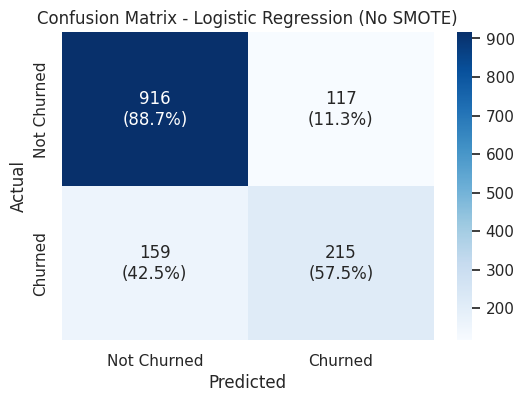

In [ ]:
import numpy as np

cm = confusion_matrix(y_test, y_pred_lr)
cm_percent = cm / cm.sum(axis=1)[:, None]

labels = ['Not Churned', 'Churned']

boxed = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        boxed[i, j] = f"{cm[i,j]}\n({cm_percent[i,j]*100:.1f}%)"

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=boxed, fmt="", cmap="Blues",
            xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression (No SMOTE)")
plt.show()


In [ ]:
# 7. Logistic Regression Coefficients (feature importance)

feature_names = X.columns
coefs = log_reg_pipeline.named_steps['log_reg'].coef_[0]

coef_df = pd.DataFrame({
    'feature': feature_names,
    'coef': coefs
})

coef_df['abs_coef'] = coef_df['coef'].abs()
coef_df = coef_df.sort_values('abs_coef', ascending=False)

coef_df.head(15)   # top 15 most important features

,feature,coef,abs_coef
3,tenure,-1.340230,1.340230
6,MonthlyCharges,-0.845896,0.845896
11,InternetService_Fiber optic,0.724660,0.724660
7,TotalCharges,0.632460,0.632460
26,Contract_Two year,-0.597358,0.597358
25,Contract_One year,-0.310502,0.310502
22,StreamingTV_Yes,0.248959,0.248959
24,StreamingMovies_Yes,0.235700,0.235700
10,MultipleLines_Yes,0.214014,0.214014
28,PaymentMethod_Electronic check,0.182509,0.182509


In [ ]:
# 8. Decision Tree Classifier

tree_clf = DecisionTreeClassifier(
    max_depth=4,        # you can tune this
    min_samples_split=50,
    random_state=42
)

tree_clf.fit(X_train, y_train)

y_pred_tree = tree_clf.predict(X_test)
y_proba_tree = tree_clf.predict_proba(X_test)[:, 1]

print("=== Decision Tree Performance on Test Set ===")
print("Accuracy: ", accuracy_score(y_test, y_pred_tree))
print("Precision:", precision_score(y_test, y_pred_tree))
print("Recall:   ", recall_score(y_test, y_pred_tree))
print("ROC-AUC:  ", roc_auc_score(y_test, y_proba_tree))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_tree))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_tree))


=== Decision Tree Performance on Test Set ===
Accuracy:  0.783226723525231
Precision: 0.6131147540983607
Recall:    0.5
ROC-AUC:   0.8200350984361007

Confusion Matrix:
[[915 118]
 [187 187]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.61      0.50      0.55       374

    accuracy                           0.78      1407
   macro avg       0.72      0.69      0.70      1407
weighted avg       0.77      0.78      0.78      1407



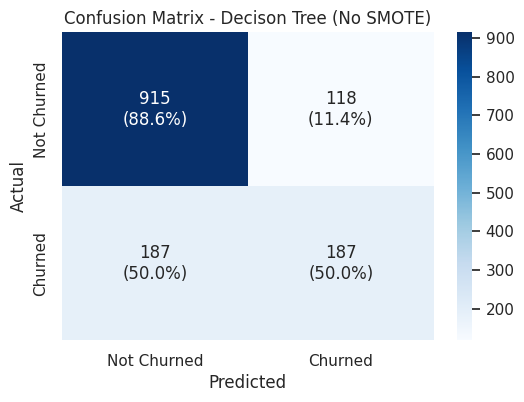

In [ ]:
cm = confusion_matrix(y_test, y_pred_tree)
cm_percent = cm / cm.sum(axis=1)[:, None]

labels = ['Not Churned', 'Churned']

boxed = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        boxed[i, j] = f"{cm[i,j]}\n({cm_percent[i,j]*100:.1f}%)"

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=boxed, fmt="", cmap="Blues",
            xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Decison Tree (No SMOTE)")
plt.show()


In [ ]:
# 9. K-Fold Cross-Validation (accuracy)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Logistic Regression CV
log_reg_cv_scores = cross_val_score(
    log_reg_pipeline,
    X, y,
    cv=cv,
    scoring='accuracy'
)

print("=== Logistic Regression CV Accuracy ===")
print("Fold scores:", log_reg_cv_scores)
print("Mean accuracy:", log_reg_cv_scores.mean())
print("Std dev:", log_reg_cv_scores.std())

# Decision Tree CV
tree_cv_scores = cross_val_score(
    tree_clf,
    X, y,
    cv=cv,
    scoring='accuracy'
)

print("\n=== Decision Tree CV Accuracy ===")
print("Fold scores:", tree_cv_scores)
print("Mean accuracy:", tree_cv_scores.mean())
print("Std dev:", tree_cv_scores.std())

=== Logistic Regression CV Accuracy ===
Fold scores: [0.80668088 0.80739161 0.79587482 0.80227596 0.81294452]
Mean accuracy: 0.8050335601003316
Std dev: 0.005698144632501366

=== Decision Tree CV Accuracy ===
Fold scores: [0.79175551 0.79175551 0.76671408 0.77596017 0.79800853]
Mean accuracy: 0.7848387608796094
Std dev: 0.011631500871054818


In [ ]:
# 10. Decision Tree feature importance

tree_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': tree_clf.feature_importances_
}).sort_values('importance', ascending=False)

tree_importance.head(15)

,feature,importance
3,tenure,0.481266
11,InternetService_Fiber optic,0.369526
23,StreamingMovies_No internet service,0.029204
28,PaymentMethod_Electronic check,0.028802
7,TotalCharges,0.023061
26,Contract_Two year,0.021061
13,OnlineSecurity_No internet service,0.016797
6,MonthlyCharges,0.015899
4,PhoneService,0.008274
20,TechSupport_Yes,0.006110


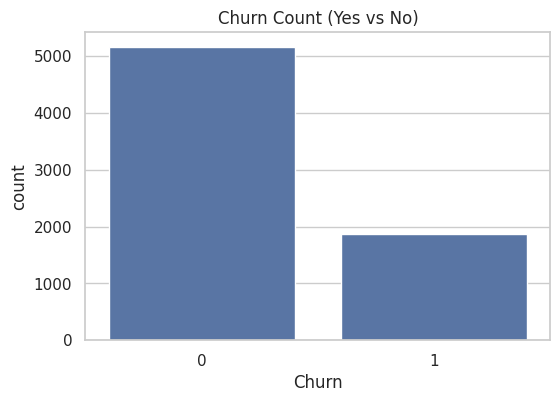

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(x=df["Churn"])
plt.title("Churn Count (Yes vs No)")
plt.show()

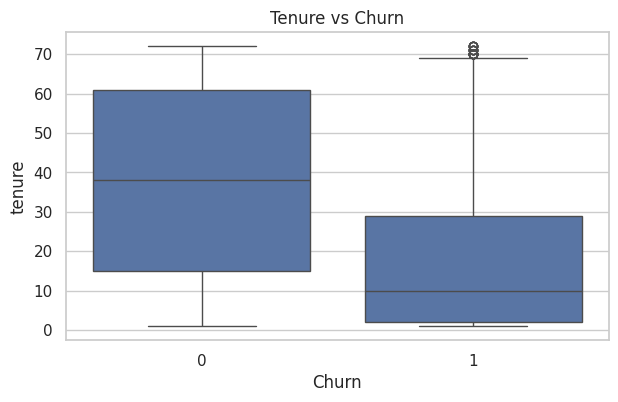

In [ ]:
plt.figure(figsize=(7,4))
sns.boxplot(x=df["Churn"], y=df["tenure"])
plt.title("Tenure vs Churn")
plt.show()

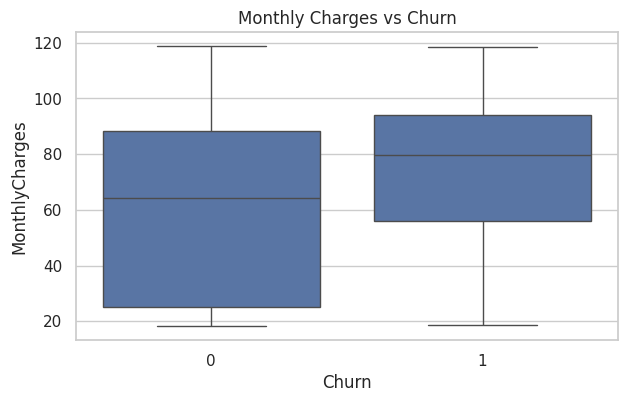

In [ ]:
plt.figure(figsize=(7,4))
sns.boxplot(x=df["Churn"], y=df["MonthlyCharges"])
plt.title("Monthly Charges vs Churn")
plt.show()

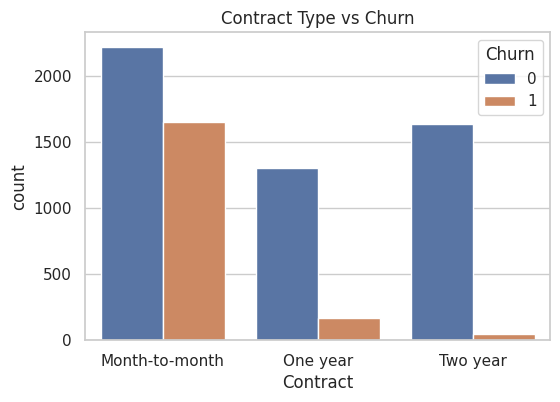

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x=df["Contract"], hue=df["Churn"])
plt.title("Contract Type vs Churn")
plt.show()

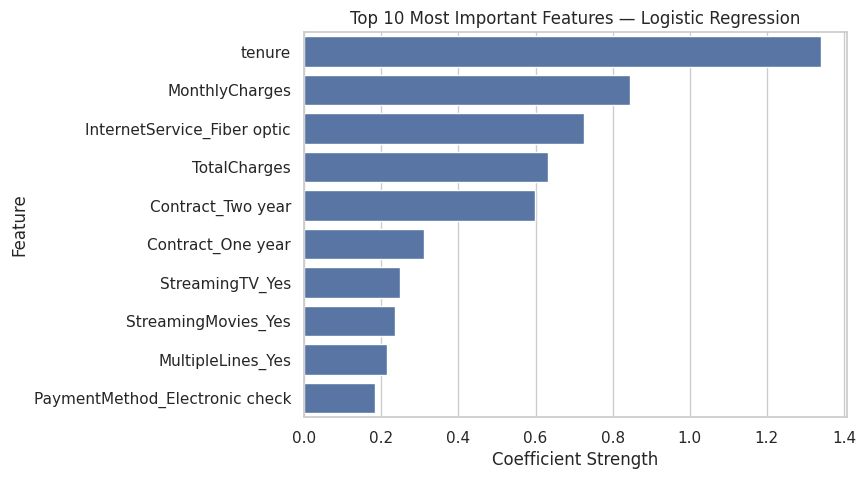

In [ ]:
top10 = coef_df.sort_values('abs_coef', ascending=False).head(10)

plt.figure(figsize=(7,5))
sns.barplot(x=top10['abs_coef'], y=top10['feature'])
plt.title("Top 10 Most Important Features — Logistic Regression")
plt.xlabel("Coefficient Strength")
plt.ylabel("Feature")
plt.show()

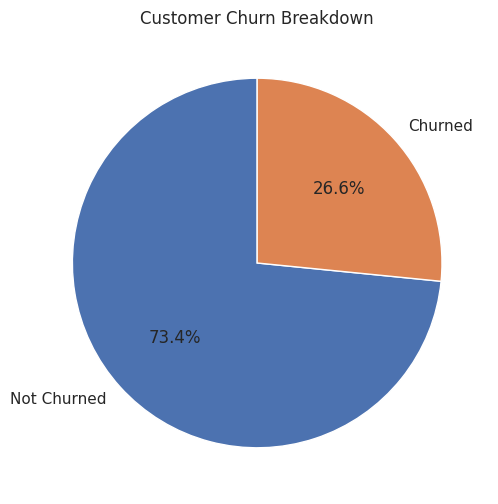

In [ ]:
#Make a pie chart showing churn rate
import matplotlib.pyplot as plt

# Count churn values
churn_counts = df["Churn"].value_counts()

# Pie chart
plt.figure(figsize=(6,6))
plt.pie(
    churn_counts,
    labels = ["Not Churned", "Churned"],
    autopct = "%1.1f%%",
    startangle = 90
)
plt.title("Customer Churn Breakdown")
plt.show()

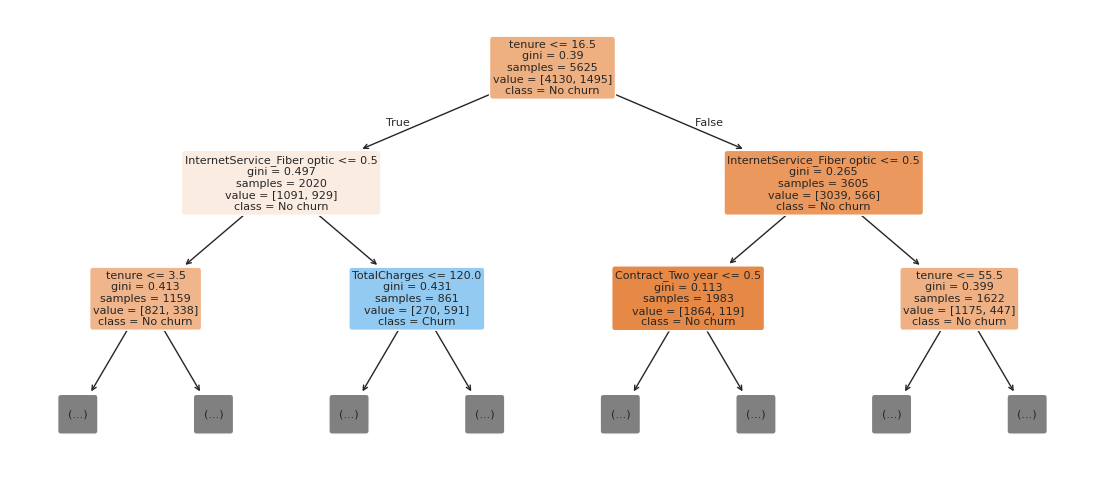

In [ ]:
from sklearn import tree
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 6))

tree.plot_tree(
    tree_clf,
    feature_names=X_train.columns,
    class_names=["No churn", "Churn"],
    filled=True,
    rounded=True,
    fontsize=8,
    max_depth=2   # <<--- LIMIT TREE TO 2 LEVELS
)

plt.show()



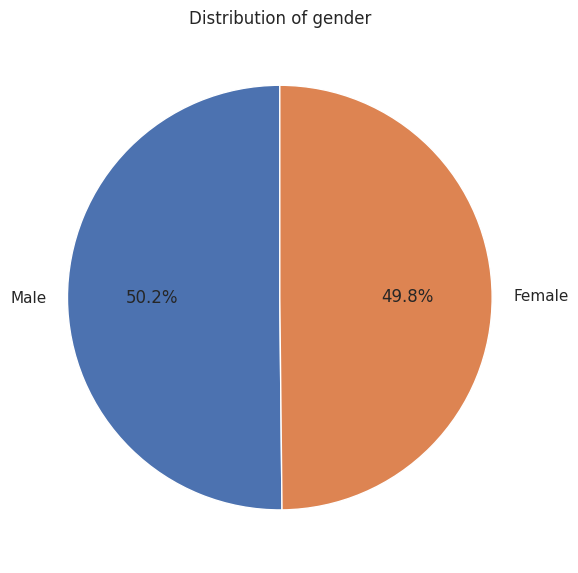

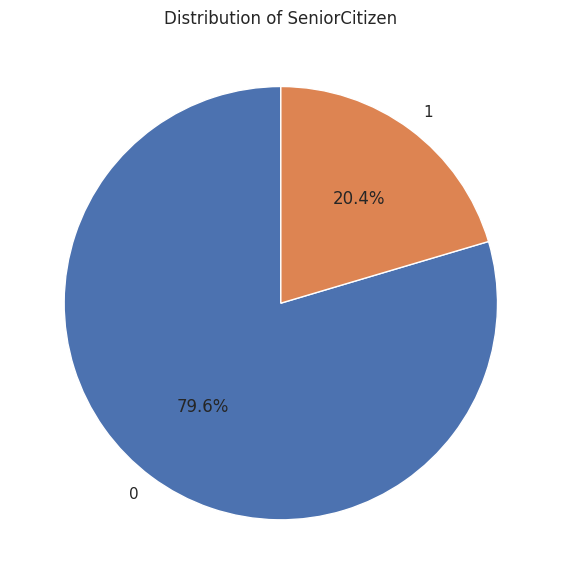

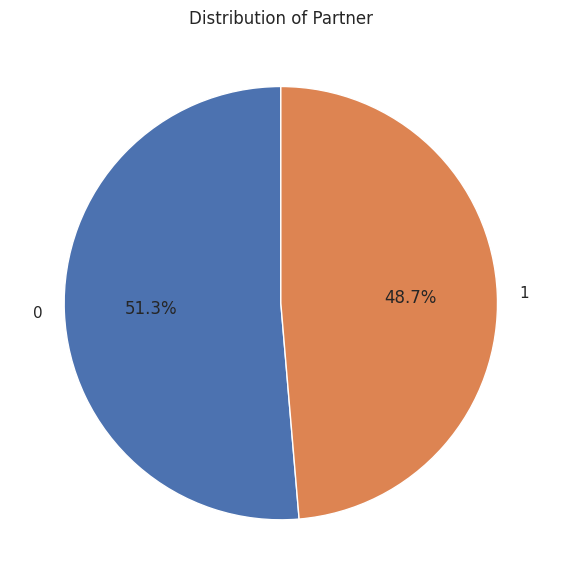

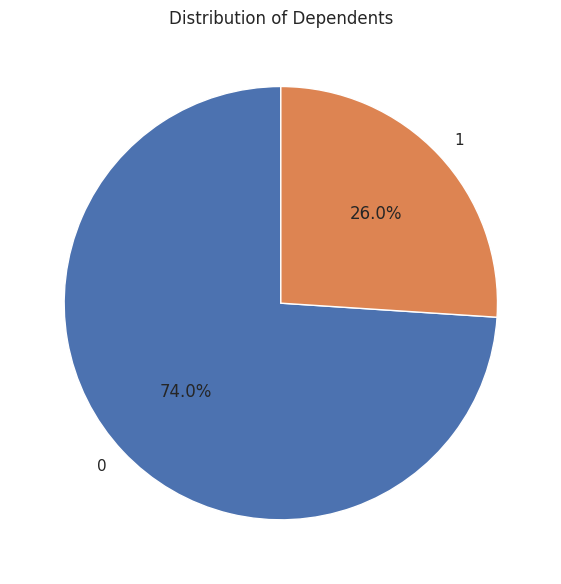

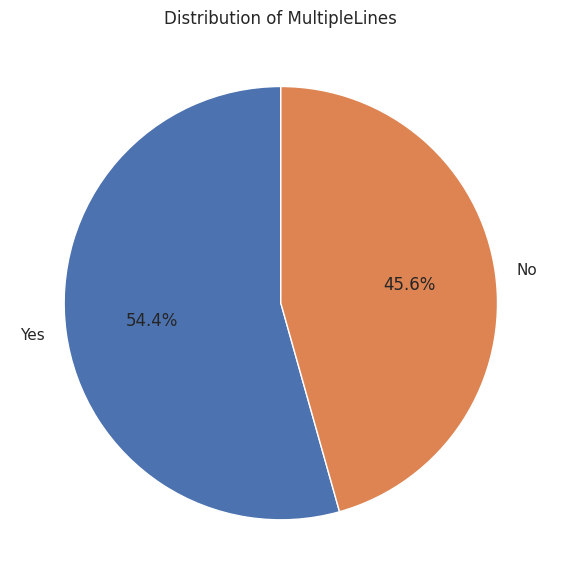

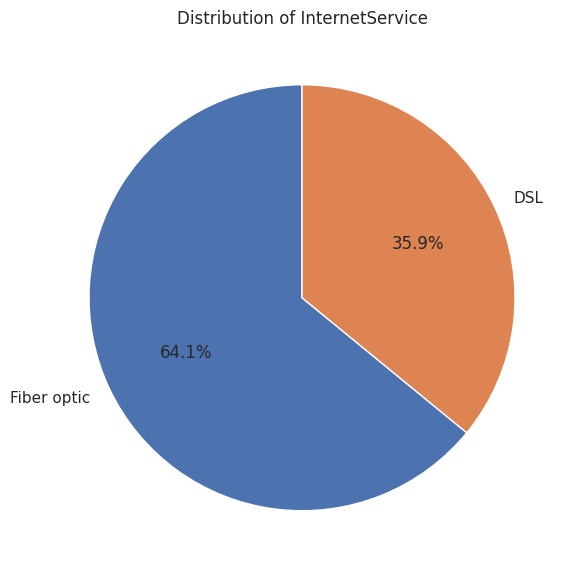

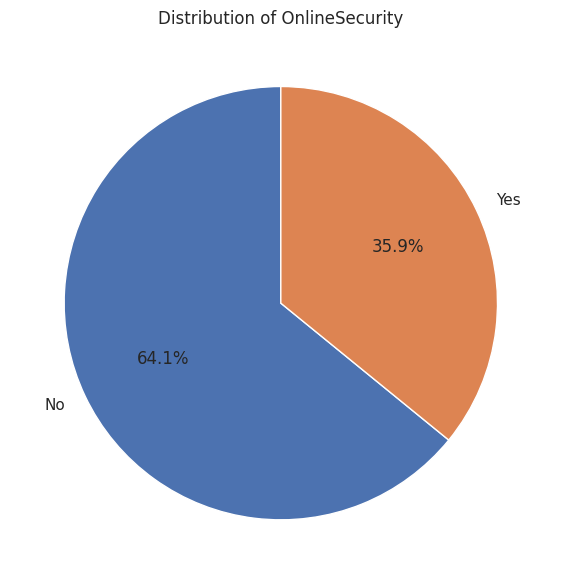

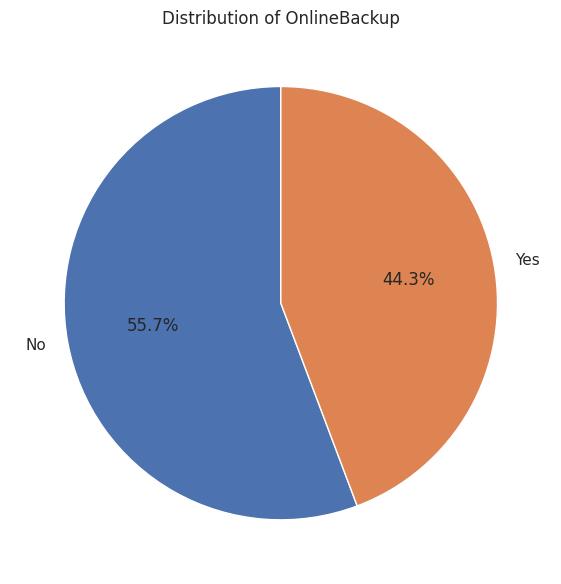

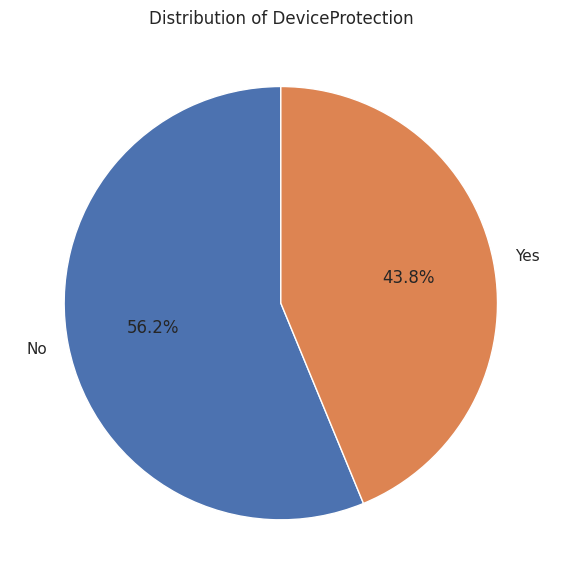

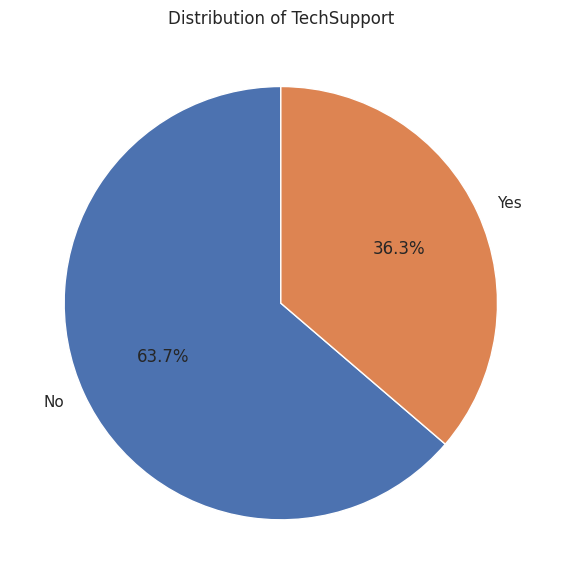

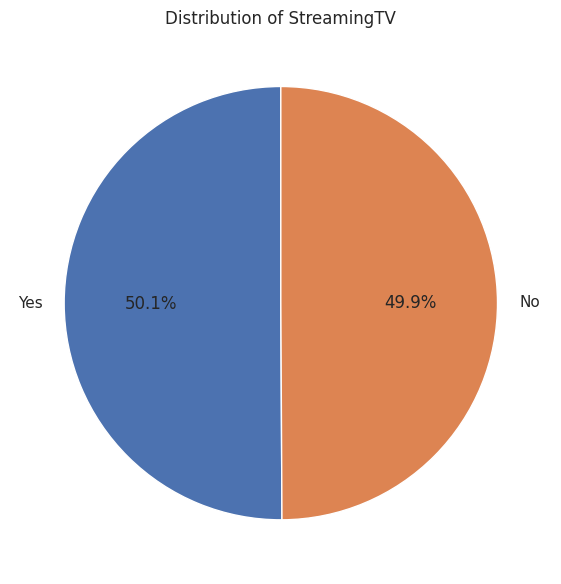

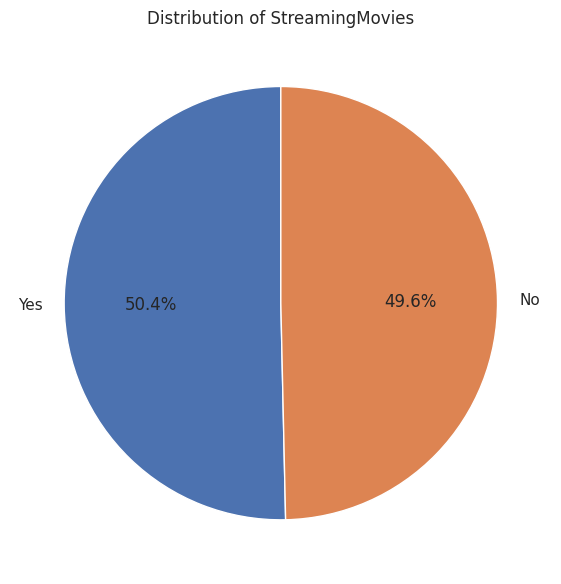

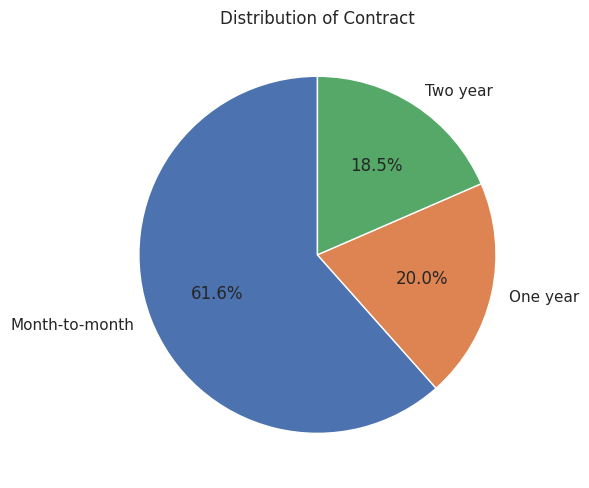

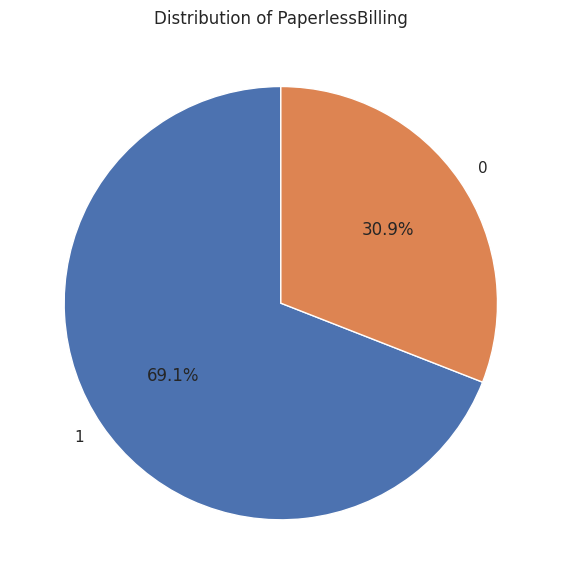

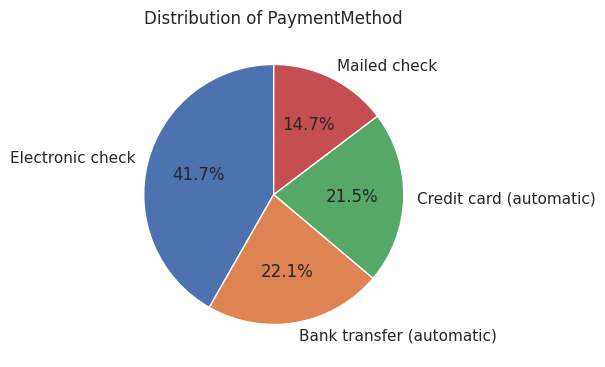

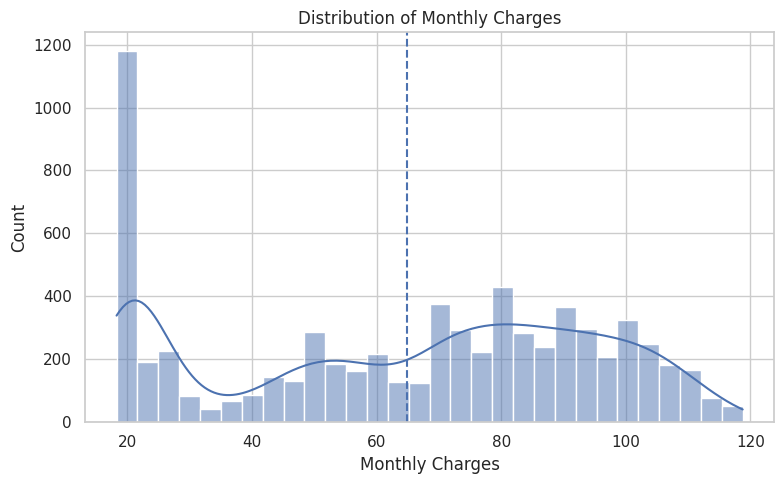

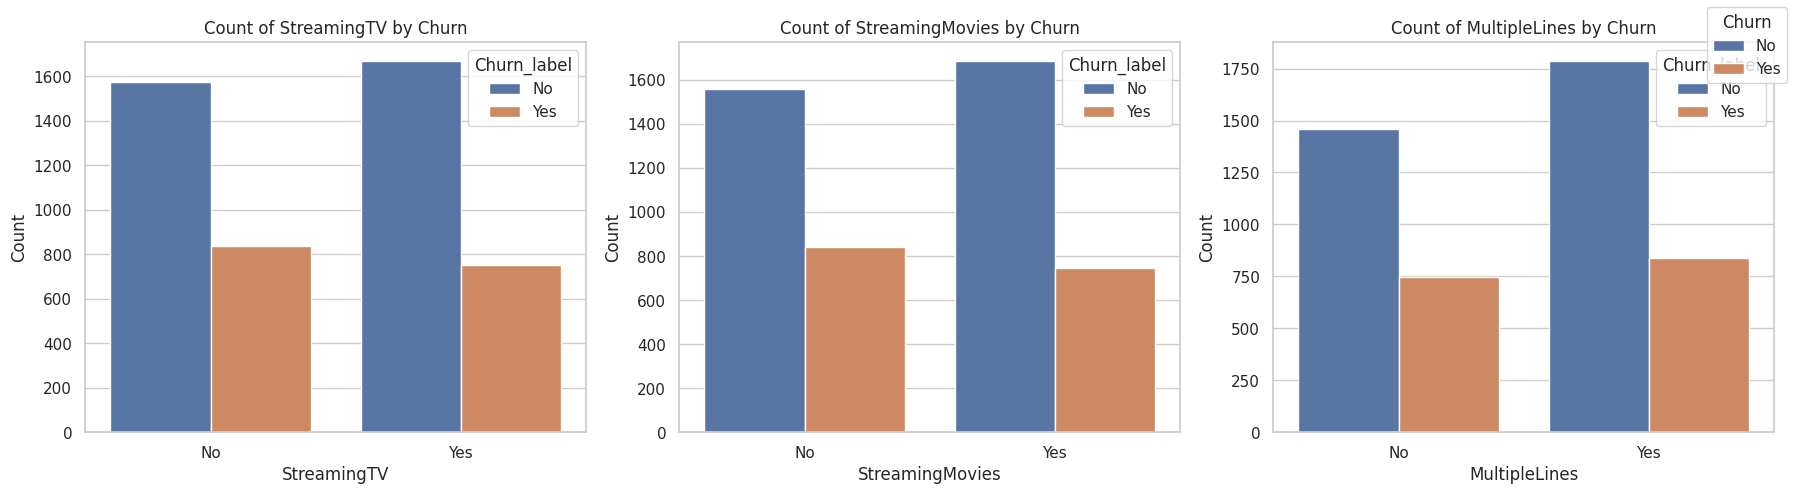

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# -----------------------------------------------------------
# 1. Create a CLEAN DATAFRAME (df1)
# -----------------------------------------------------------
df1 = df.copy()

# Remove "No phone service" from MultipleLines
if "MultipleLines" in df1.columns:
    df1 = df1[df1["MultipleLines"] != "No phone service"]

# Remove PhoneService = 0 (no phone service)
if "PhoneService" in df1.columns:
    df1 = df1[df1["PhoneService"] == 1]

# Remove "No internet service" categories to clean binary features
internet_remove_cols = [
    "OnlineSecurity", "OnlineBackup", "DeviceProtection",
    "TechSupport", "StreamingTV", "StreamingMovies"
]

for col in internet_remove_cols:
    if col in df1.columns:
        df1 = df1[df1[col] != "No internet service"]

# Create Churn label if needed
if "Churn_label" not in df1.columns:
    if df1["Churn"].dtype != "O":
        df1["Churn_label"] = df1["Churn"].map({0: "No", 1: "Yes"})
    else:
        df1["Churn_label"] = df1["Churn"]

# -----------------------------------------------------------
# 2. PIE CHARTS USING CLEANED df1
# -----------------------------------------------------------

pie_cols = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents',
    'MultipleLines', 'InternetService', 'OnlineSecurity',
    'OnlineBackup', 'DeviceProtection', 'TechSupport',
    'StreamingTV', 'StreamingMovies', 'Contract',
    'PaperlessBilling', 'PaymentMethod'
]

for col in pie_cols:
    if col in df1.columns:
        plt.figure(figsize=(6, 6))
        df1[col].value_counts().plot(
            kind='pie',
            autopct='%1.1f%%',
            startangle=90
        )
        plt.title(f"Distribution of {col}")
        plt.ylabel("")
        plt.tight_layout()
        plt.show()

# -----------------------------------------------------------
# 3. HISTOGRAM OF MONTHLY CHARGES
# -----------------------------------------------------------

plt.figure(figsize=(8, 5))
sns.histplot(df['MonthlyCharges'], bins=30, kde=True)
plt.axvline(df['MonthlyCharges'].mean(), linestyle='--')
plt.title("Distribution of Monthly Charges")
plt.xlabel("Monthly Charges")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# -----------------------------------------------------------
# 4. COUNT PLOTS (Instead of boxplots)
# -----------------------------------------------------------

features_for_counts = ["StreamingTV", "StreamingMovies", "MultipleLines"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, feature in zip(axes, features_for_counts):
    sns.countplot(
        data=df1,
        x=feature,
        hue="Churn_label",
        ax=ax
    )
    ax.set_title(f"Count of {feature} by Churn")
    ax.set_xlabel(feature)
    ax.set_ylabel("Count")

# Shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Churn", loc="upper right")

plt.tight_layout()
plt.show()


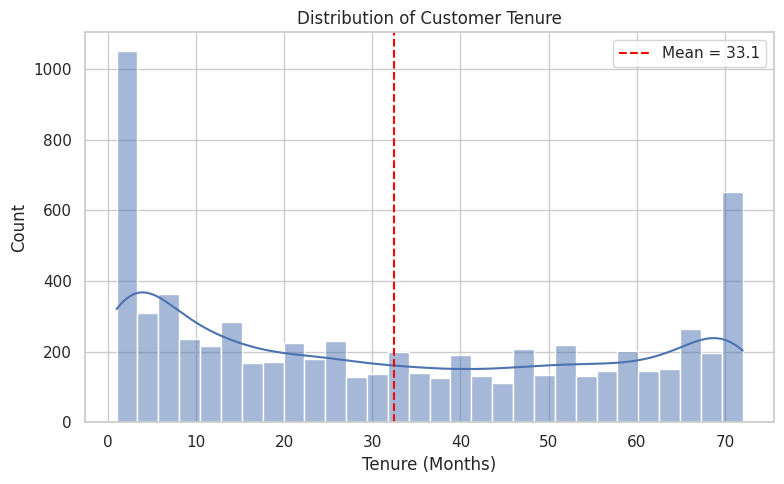

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['tenure'], bins=30, kde=True)
plt.axvline(df['tenure'].mean(), color='red', linestyle='--', label=f"Mean = {df1['tenure'].mean():.1f}")
plt.title("Distribution of Customer Tenure")
plt.xlabel("Tenure (Months)")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()


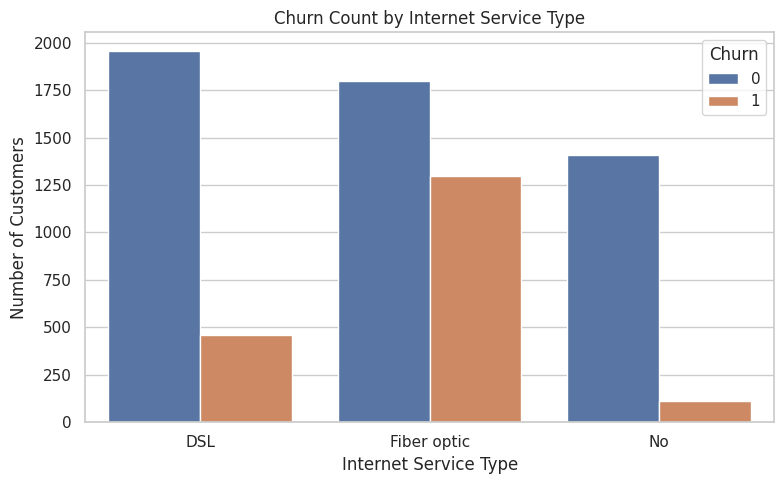

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(
    data=df,
    x="InternetService",
    hue="Churn"   # <-- FIXED
)

plt.title("Churn Count by Internet Service Type")
plt.xlabel("Internet Service Type")
plt.ylabel("Number of Customers")
plt.tight_layout()
plt.show()

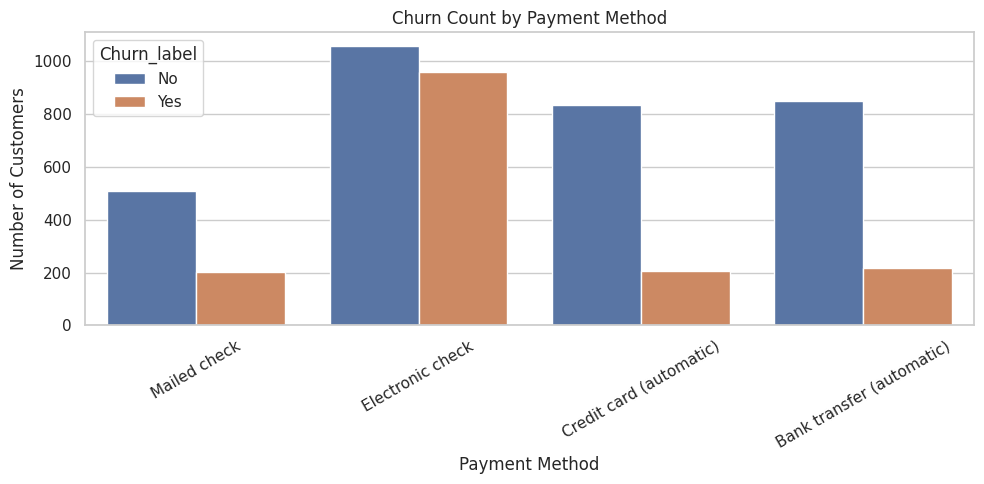

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(
    data=df1,
    x="PaymentMethod",
    hue="Churn_label"
)
plt.title("Churn Count by Payment Method")
plt.xlabel("Payment Method")
plt.ylabel("Number of Customers")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


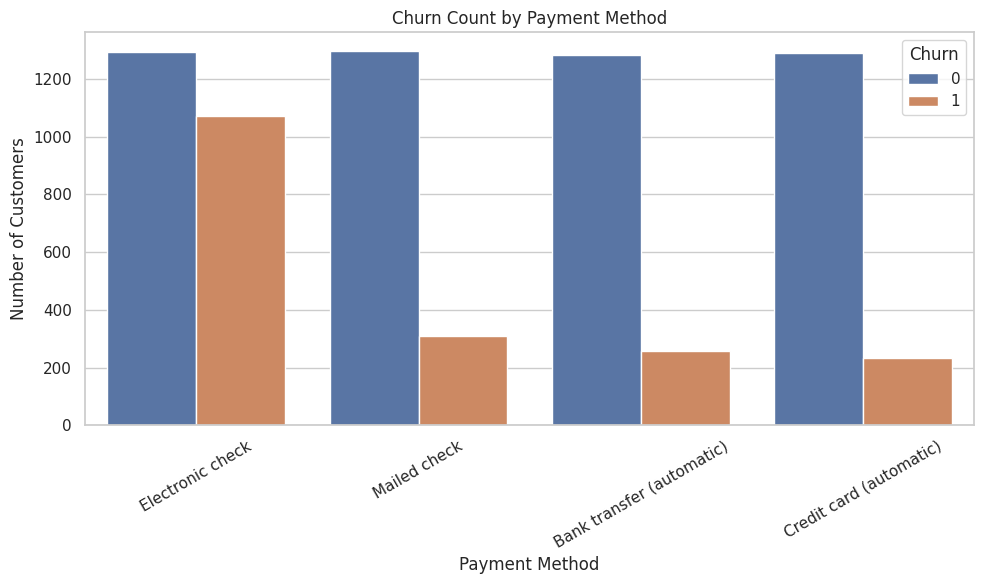

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, x="PaymentMethod", hue="Churn")
plt.title("Churn Count by Payment Method")
plt.xlabel("Payment Method")
plt.ylabel("Number of Customers")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [ ]:
#Standardize Variables to get Coefficient Meaning

In [ ]:
#Use smote to rebalance data

In [ ]:
#improved models with smote
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline   # key point

# 1) Features and target
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']    # 0 = no churn, 1 = churn

# 2) Train–test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3) Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
#Logistic Regression with SMOTE + scaling + CV
from imblearn.pipeline import Pipeline as ImbPipeline

log_reg_pipeline = ImbPipeline(steps=[
    ('scaler', StandardScaler()),        # standardize
    ('smote', SMOTE(random_state=42)),   # rebalance
    ('clf', LogisticRegression(
        max_iter=1000,
        solver='liblinear'
    ))
])

param_grid_lr = {
    'clf__C': [0.01, 0.1, 1, 10]
}

grid_lr = GridSearchCV(
    estimator=log_reg_pipeline,
    param_grid=param_grid_lr,
    cv=cv,
    scoring='recall',     # focus on catching churners (class 1)
    n_jobs=-1
)

grid_lr.fit(X_train, y_train)

print("Best Logistic C:", grid_lr.best_params_)
print("Best CV recall (LR):", grid_lr.best_score_)

best_lr = grid_lr.best_estimator_

y_pred_lr = best_lr.predict(X_test)
y_prob_lr = best_lr.predict_proba(X_test)[:, 1]

print("\n=== Logistic Regression with SMOTE & CV ===")
print("Accuracy:", (y_pred_lr == y_test).mean())
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr))
print("\nClassification report:")
print(classification_report(y_test, y_pred_lr))
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred_lr))

Best Logistic C: {'clf__C': 10}
Best CV recall (LR): 0.7933110367892977

=== Logistic Regression with SMOTE & CV ===
Accuracy: 0.7306325515280739
ROC-AUC: 0.8333613741193036

Classification report:
              precision    recall  f1-score   support

           0       0.90      0.71      0.80      1033
           1       0.50      0.78      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.73      0.75      1407


Confusion matrix:
[[737 296]
 [ 83 291]]


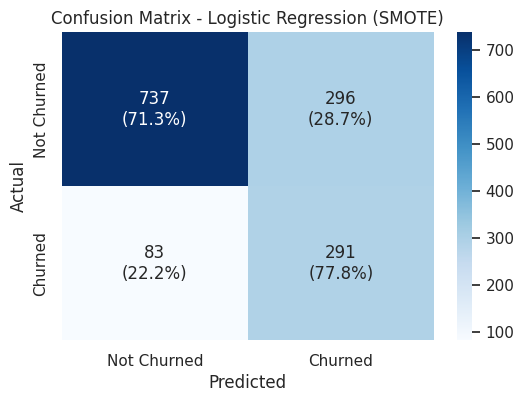

In [ ]:
import numpy as np

cm = confusion_matrix(y_test, y_pred_lr)
cm_percent = cm / cm.sum(axis=1)[:, None]

labels = ['Not Churned', 'Churned']

boxed = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        boxed[i, j] = f"{cm[i,j]}\n({cm_percent[i,j]*100:.1f}%)"

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=boxed, fmt="", cmap="Blues",
            xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression (SMOTE)")
plt.show()


In [ ]:
#Decision Tree with SMOTE + scaling + CV
tree_pipeline = ImbPipeline(steps=[
    ('scaler', StandardScaler()),        # keep for consistency with prof’s request
    ('smote', SMOTE(random_state=42)),
    ('clf', DecisionTreeClassifier(random_state=42))
])

param_grid_tree = {
    'clf__max_depth': [3, 4, 5, 6],
    'clf__min_samples_split': [20, 50, 100]
}

grid_tree = GridSearchCV(
    estimator=tree_pipeline,
    param_grid=param_grid_tree,
    cv=cv,
    scoring='recall',
    n_jobs=-1
)

grid_tree.fit(X_train, y_train)

print("Best Tree params:", grid_tree.best_params_)
print("Best CV recall (Tree):", grid_tree.best_score_)

best_tree = grid_tree.best_estimator_

y_pred_tree = best_tree.predict(X_test)
y_prob_tree = best_tree.predict_proba(X_test)[:, 1]

print("\n=== Decision Tree with SMOTE & CV ===")
print("Accuracy:", (y_pred_tree == y_test).mean())
print("ROC-AUC:", roc_auc_score(y_test, y_prob_tree))
print("\nClassification report:")
print(classification_report(y_test, y_pred_tree))
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred_tree))

Best Tree params: {'clf__max_depth': 3, 'clf__min_samples_split': 20}
Best CV recall (Tree): 0.8775919732441471

=== Decision Tree with SMOTE & CV ===
Accuracy: 0.6361051883439943
ROC-AUC: 0.78232369247972

Classification report:
              precision    recall  f1-score   support

           0       0.92      0.55      0.69      1033
           1       0.41      0.87      0.56       374

    accuracy                           0.64      1407
   macro avg       0.67      0.71      0.62      1407
weighted avg       0.79      0.64      0.66      1407


Confusion matrix:
[[569 464]
 [ 48 326]]


In [ ]:
#Plot Decision Tree after SMOTE
grid_tree.fit(X_train, y_train)
best_tree = grid_tree.best_estimator_


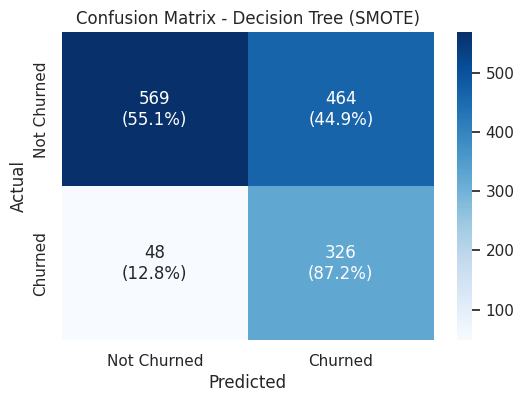

In [ ]:
cm = confusion_matrix(y_test, y_pred_tree)
cm_percent = cm / cm.sum(axis=1)[:, None]

labels = ['Not Churned', 'Churned']

boxed = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        boxed[i, j] = f"{cm[i,j]}\n({cm_percent[i,j]*100:.1f}%)"

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=boxed, fmt="", cmap="Blues",
            xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Decision Tree (SMOTE)")
plt.show()

In [ ]:
tree_clf = best_tree.named_steps['clf']   # classifier inside pipeline

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

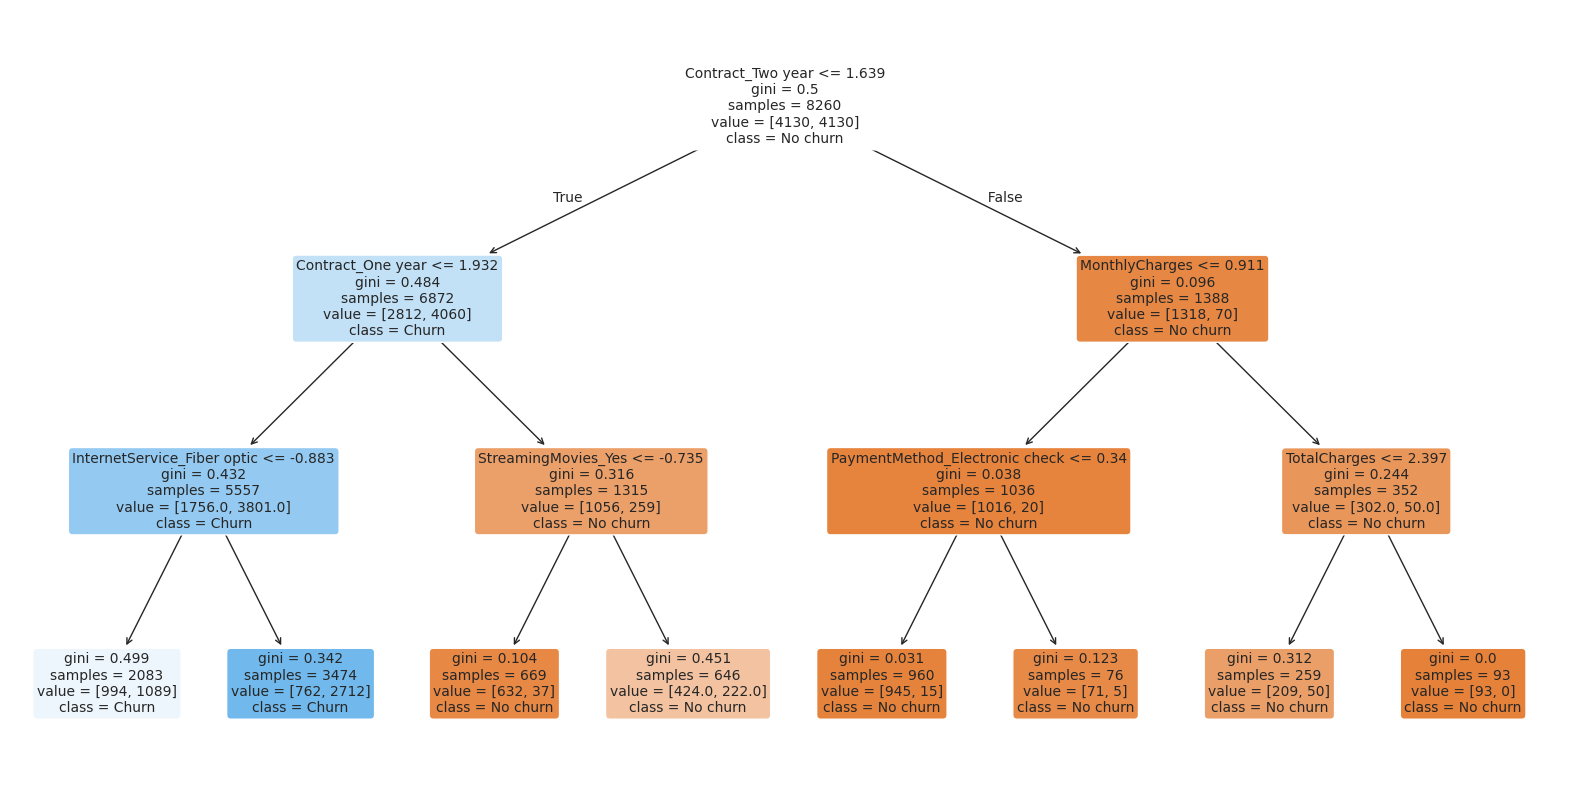

In [ ]:
plt.figure(figsize=(20,10))
plot_tree(
    tree_clf,
    feature_names=X.columns,
    class_names=["No churn", "Churn"],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.show()

In [ ]:
simple_tree = DecisionTreeClassifier(
    max_depth=3,
    min_samples_split=20,
    random_state=42
)

simple_tree.fit(X_train, y_train)  # train again (not with SMOTE)

DecisionTreeClassifier(max_depth=3, min_samples_split=20, random_state=42)

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
# Target and features
X = df.drop('Churn', axis=1)
y = df['Churn']   # 1 = Yes, 0 = No

# Identify categorical + numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
])

# Random Forest Pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('rf', RandomForestClassifier(random_state=42))
])

# Hyperparameter tuning
param_grid = {
    'rf__n_estimators': [200, 300],
    'rf__max_depth': [5, 8, 12, None],
    'rf__min_samples_split': [2, 10, 20]
}
grid_rf = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='recall',  # emphasize catching churners
    n_jobs=-1
)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Fit model
grid_rf.fit(X_train, y_train)

# Predictions
y_pred = grid_rf.predict(X_test)

# Print results
print("=== Random Forest Performance on Test Set ===")
print("Best Params:", grid_rf.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

=== Random Forest Performance on Test Set ===
Best Params: {'rf__max_depth': 12, 'rf__min_samples_split': 2, 'rf__n_estimators': 300}
Accuracy: 0.7967306325515281
Precision: 0.6466666666666666
Recall: 0.5187165775401069
F1 Score: 0.5756676557863502

Confusion Matrix:
[[927 106]
 [180 194]]
